# Simulations of cereal monocrops and intercrops

In [3]:
import math
import numpy as np
import sympy as sp
from random import *
import random as rd
from itertools import product

from openalea.plantgl.all import Vector3
from oawidgets.plantgl import *

from alinea.caribu.CaribuScene import CaribuScene
from alinea.caribu.data_samples import data_path

# from archicrop
from openalea.archicrop.cereals_leaf import parametric_leaf
from openalea.archicrop.plant_shape import geometric_dist, bell_shaped_dist, compute_leaf_area
from openalea.archicrop.plant_design import leaf_azimuth
from openalea.archicrop.cereals import build_shoot
from openalea.archicrop.display import display_mtg, build_scene, display_scene
from openalea.archicrop.geometry import stem_mesh, leaf_mesh, leaf_mesh_for_growth, CerealsVisitor, CerealsTurtle

from openalea.archicrop.cereals import build_shoot
from openalea.archicrop.stand import regular_plot, agronomic_plot

## Generate potential plant

In [3]:
def generate_potential_plant(archi_parameters):
    shoot, potential_plant = build_shoot(*archi_parameters)
    return potential_plant

## 

In [4]:
def distribute_among_plants(constraints_crop, nb_of_plants):
    constraint_crop_height = constraints_crop[0]
    constraint_crop_LAI = constraints_crop[1]
    constraint_plants_height = constraint_crop_height
    constraint_plants_LA = constraint_crop_LAI 
    constraints_plants = [constraint_plants_height, constraint_plants_LA]
    return constraints_plants

In [5]:
# Define the variable and parameters
s = sp.symbols('s')
L, wl = sp.symbols('L, wl') 

# Define the scaled leaf shape function with parameters
beta = -2 * (-2.3 + math.sqrt(2.3))
gamma = 2 * math.sqrt(2.3) - 2.3
r = wl * L * (-2.3 * (s / L) ** 2 + beta * (s / L) + gamma)

# Reflect the function to the axis x=0.5 
reflected_r = r.subs(s, -s+L).simplify()

# Find the indefinite integral (primitive)
primitive_f = sp.integrate(reflected_r, s)

1.0*s*wl*(3.03315017762062*L - 2.3*s)/L
1.51657508881031*s**2*wl - 0.766666666666667*s**3*wl/L


In [6]:
def leaf_area_function_of_length(s, L, wl=0.12):
    return 2 * (1.51657508881031*s**2*wl - 0.766666666666667*s**3*wl/L)


# Test
wl = 0.12
L = 100
w = wl*L
constraint_LA = 1799
current_leaf_length = 0

s = sp.symbols('s')

# Define the equation
equation = constraint_LA + leaf_area_function_of_length(current_leaf_length, L) - leaf_area_function_of_length(s, L)
# equation = 0.1/(2*1) + leaf_area_function_of_length(0.5, 1) - leaf_area_function_of_length(s, 1)

# Solve the equation, restricting the domain to real numbers
real_solutions = sp.solveset(equation, s, domain=sp.S.Reals)
print(real_solutions)
for sol in real_solutions:
    if current_leaf_length < sol < L:
        unique_solution = sol
        # break

print("The unique solution is :", unique_solution)
print("The leaf length increment is :", unique_solution - current_leaf_length)
print("The leaf area increment is :", leaf_area_function_of_length(unique_solution, L) - leaf_area_function_of_length(current_leaf_length, L))

{-61.4137739302517, 99.9556796139342, 159.272236335053}
The unique solution is : 99.9556796139342
The leaf length increment is : 99.9556796139342
The leaf area increment is : 1799.00000000000


In [7]:
# in file geometry

def compute_nb_of_growing_organs(g, time):

    nb_of_growing_internodes = 0
    nb_of_growing_leaves = 0

    axes = g.vertices(scale=1)
    metamer_scale = g.max_scale()

    for axis in axes:
        v = next(g.component_roots_at_scale_iter(axis, scale=metamer_scale))

        for metamer in pre_order2(g, v):
            
            n = g.node(metamer)
            if n.label.startswith("Leaf") or n.label.startswith("Stem"):
                if n.start_tt <= time < n.end_tt: # and n.visible_length < n.mature_length:  # organ growing   
                    if n.label.startswith("Leaf"):
                        nb_of_growing_leaves += 1 
                    if n.label.startswith("Stem"):
                        nb_of_growing_internodes += 1

    return nb_of_growing_internodes, nb_of_growing_leaves


def compute_leaf_length_increment(constraint_LA, leaf):
    """returns the leaf length of a leaf given a leaf area"""

    # def scaled_leaf_shape(s, L, alpha=-2.3):
    #     beta = -2 * (alpha + np.sqrt(-alpha))
    #     gamma = 2 * np.sqrt(-alpha) + alpha
    #     r = alpha * (s / L) ** 2 + beta * (s / L) + gamma
    #     return r


    L = leaf.mature_length
    current_leaf_length = leaf.visible_length
    alpha = -2.3

    # # compute current leaf area
    # if current_leaf_length == 0:
    #     current_blade_area = 0
    # else:
    #     lower_bound = max(L - current_leaf_length, 0.0)
    #     upper_bound = L
    #     current_blade_area, error = quad(
    #         scaled_leaf_shape, lower_bound, upper_bound, args=(L, alpha)
    #     )
    #     current_blade_area = 2 * leaf.shape_max_width * blade_area
    # print(current_blade_area)

    
    def leaf_area_function_of_length(s, L, wl=0.12):
        '''returns the current leaf area (i.e. twice the integral of leaf shape) given the current length s'''
        return 2 * (1.51657508881031*s**2*wl - 0.766666666666667*s**3*wl/L)
    
    wl = 0.12
    w = wl*L
    
    s = sp.symbols('s')
    
    # Define the equation
    equation = constraint_LA + leaf_area_function_of_length(current_leaf_length, L) - leaf_area_function_of_length(s, L)
    
    # Solve the equation, restricting the domain to real numbers
    real_solutions = sp.solveset(equation, s, domain=sp.S.Reals)
    print(real_solutions)
    for sol in real_solutions:
        if current_leaf_length < sol < L:
            unique_solution = sol
            # break

    leaf_length_increment = unique_solution - current_leaf_length
    
    print("The unique solution is :", unique_solution)
    print("The leaf length increment is :", leaf_length_increment)
    print("The leaf area increment is :", leaf_area_function_of_length(unique_solution, L) - leaf_area_function_of_length(current_leaf_length, L))
    
    return leaf_length_increment


def compute_continuous_element_with_constraint(
    element_node, time, constraint_on_each_leaf, constraint_on_each_internode, 
    constraint_to_distribute_LA, constraint_to_distribute_height, 
    nb_of_updated_leaves, nb_of_updated_internodes, classic=False
):  # see maybe with *kwarg, **kwds, etc. for time
    """compute geometry of Adel base elements (LeafElement and StemElement)
    element_node should be a mtg node proxy"""
    n = element_node
    geom = None

    # added by Oriane, for continuous growth with constraint
    
    
    # starting from the lowest (oldest) growing organ
    if n.start_tt <= time < n.end_tt and n.visible_length < n.mature_length:  # organ growing
        # for constrained growth
        
        if n.label.startswith("Leaf"):
            # convert constraint for each organ(t) to leaf length
            leaf_length_increment = compute_leaf_length_increment(constraint_on_each_leaf, n)
            print(leaf_length_increment, n.mature_length)
            
            if n.visible_length + constraint_on_each_leaf <= n.mature_length:
                n.visible_length += constraint_on_each_leaf
                nb_of_updated_leaves += 1
                constraint_to_distribute_LA -= constraint_on_each_leaf
            else: 
                constraint_to_distribute_LA -= (n.mature_length - n.visible_length)
                n.visible_length = n.mature_length
                nb_of_updated_leaves += 1
                constraint_on_each_leaf = constraint_to_distribute_LA / (nb_of_growing_leaves - nb_of_updated_leaves)
            n.grow = True
            
        elif n.label.startswith("Stem"):
            ''' 
            h = n.visible_length
            radius = n.diameter / 2
            sheath_area = 2 * np.pi * radius * h
            '''
            if n.visible_length + constraint_on_each_internode <= n.mature_length:
                n.visible_length += constraint_on_each_internode
                nb_of_updated_internodes += 1
                constraint_to_distribute_height -= constraint_on_each_internode
            else: 
                constraint_to_distribute_height -= (n.mature_length - n.visible_length)
                n.visible_length = n.mature_length
                nb_of_updated_internodes += 1
                constraint_on_each_internode = constraint_to_distribute_height / (nb_of_growing_internodes - nb_of_updated_internodes)
            n.grow = True

    elif time < n.start_tt:  # organ not yet appeared
        if n.label.startswith("Leaf") or n.label.startswith("Stem"):
            n.visible_length = 0.0
            n.grow = False

    elif time >= n.end_tt and n.visible_length < n.mature_length:  # organ reaches maturity below potential 
        if n.label.startswith("Leaf") or n.label.startswith("Stem"):
            n.visible_length = n.visible_length
            n.grow = True

    elif time >= n.end_tt:  # organ reaches maturity at potential
        if n.label.startswith("Leaf"):
            n.visible_length = n.mature_length
            n.grow = True
        elif n.label.startswith("Stem"):
            n.visible_length = n.mature_length
            n.grow = True

    
    if n.label.startswith("Leaf"):  # leaf element
        if n.visible_length > 0.0001:  # filter less than 0.001 mm leaves
            if n.shape is not None and n.srb is not None:
                geom = leaf_mesh_for_growth(
                    n.shape,
                    n.mature_length,
                    n.shape_max_width,
                    n.visible_length,
                    n.srb,
                    n.srt,
                    # flipx allows x-> -x to place the shape along
                    #  with the tiller positioned with
                    # turtle.down()
                    flipx=True,
                    stem_diameter=n.stem_diameter,
                )
            if n.lrolled > 0:
                rolled = stem_mesh(
                    n.lrolled, n.lrolled, n.d_rolled, n.d_rolled, classic
                )
                if geom is None:
                    geom = rolled
                else:
                    geom = addSets(rolled, geom, translate=(0, 0, n.lrolled))
    elif n.label.startswith("Stem"):  # stem element
        geom = stem_mesh(n.length, n.visible_length, n.diameter, n.diameter, classic)

    return geom, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes
        
    

class CerealsVisitorConstrained(CerealsVisitor):
    def __init__(self, classic):
        super().__init__(classic)

    def __call__(self, g, v, turtle, time, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes):
        # 1. retrieve the node
        n = g.node(v)

        # Go to plant position if first plant element
        if n.parent() is None:
            turtle.move(0, 0, 0)
            # initial position to be compatible with canMTG positioning
            turtle.setHead(0, 0, 1, -1, 0, 0)

        # incline turtle at the base of stems,
        if n.label.startswith("Stem"):
            azim = float(n.azimuth) if n.azimuth else 0.0
            if azim:
                # print 'node', n._vid, 'azim ', azim
                turtle.rollL(azim)

        if n.label.startswith("Leaf") or n.label.startswith("Stem"):
            # update geometry of elements
            # if n.length > 0:
            # print(v)
            # nb_of_growing_internodes, nb_of_growing_leaves = compute_nb_of_growing_organs(g, time)
            mesh, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes = compute_continuous_element_with_constraint(n, time, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes, self.classic)
            if mesh:  # To DO : reset to None if calculated so ?
                n.geometry = turtle.transform(mesh)
                n.anchor_point = turtle.getPosition()

        # 3. Update the turtle and context
        turtle.setId(v)
        if n.label.startswith("Stem"):
            if n.length > 0:
                turtle.f(n.visible_length)
            turtle.context.update({"top": turtle.getFrame()})
        if n.label.startswith("Leaf"):  # noqa: SIM102
            if n.lrolled > 0:
                turtle.f(n.lrolled)
                turtle.context.update({"top": turtle.getFrame()})


In [8]:
# in file dynamic

from openalea.mtg.traversal import pre_order2, pre_order2_with_filter
from openalea.plantgl.all import (
    Color3,
    Material,
)

from openalea.archicrop.display import build_scene


def thermal_time(g, phyllochron=50.0, plastochron=40.0, leaf_duration=1.6, stem_duration=1.6):
    """
    Add dynamic properties on the mtg to simulate development
    leaf_duration is the phyllochronic time for a leaf to develop from tip appearance to collar appearance
    stem_duration is the phyllochronic time for a stem to develop
    falling_rate (degrees / phyllochron) is the rate at which leaves fall after colar appearance
    """

    axes = g.vertices(scale=1)
    metamer_scale = g.max_scale()

    for axis in axes:
        tt_stem = 0
        tt_leaf = 0
        v = next(g.component_roots_at_scale_iter(axis, scale=metamer_scale))
        # stem_ids = g.Trunk(v)
        # nb_stems = len(stem_ids)
        # nb_sectors = 1
        dtt_stem = phyllochron * stem_duration
        dtt_leaf = phyllochron * leaf_duration

        for metamer in pre_order2(g, v):
            nm = g.node(metamer)

            if "Stem" in nm.label:
                nm.start_tt = tt_stem
                nm.end_tt = tt_stem + dtt_stem
                tt_stem += phyllochron
            elif "Leaf" in nm.label:
                nm.start_tt = tt_leaf
                nm.end_tt = tt_leaf + dtt_leaf
                tt_leaf += plastochron

    return g

### SCHEMES DEVELOPPEMENT LEAVES AND INTERNODES SUPERIMPOSED

def mtg_turtle_time_with_constraint(g, time, constraint_plants, update_visitor=None):
    """Compute the geometry on each node of the MTG using Turtle geometry.

    Update_visitor is a function called on each node in a pre order (parent before children).
    This function allow to update the parameters and state variables of the vertices.

    :Example:

        >>> def grow(node, time):

    """

    g.properties()["geometry"] = {}
    g.properties()["_plant_translation"] = {}

    max_scale = g.max_scale()


    def distribute_constraint(g, time, constraint_plants):

        # compute number of growing organs
        nb_of_growing_internodes, nb_of_growing_leaves = compute_nb_of_growing_organs(g, time)
        
        # retrieve constraint for height and LA
        constraint_plants_height = constraint_plants[0]
        constraint_plants_LA = constraint_plants[1]
    
        # set initial total amount of growth to distribute among organs
        constraint_to_distribute_height = constraint_plants_height
        constraint_to_distribute_LA = constraint_plants_LA
        # print(constraint_to_distribute_LA)
    
        # set initial distribution per organ (H: same amount for all organs)
        if nb_of_growing_leaves == 0:
            constraint_on_each_leaf = 0
        else:
            constraint_on_each_leaf = constraint_to_distribute_LA / nb_of_growing_leaves # and internodes = sheath !!!!
            # print("Constraint on each leaf:", constraint_on_each_leaf)

        if nb_of_growing_internodes == 0:
            constraint_on_each_internode = 0
        else:
            constraint_on_each_internode = constraint_to_distribute_height / nb_of_growing_internodes
    
        nb_of_updated_leaves = 0
        nb_of_updated_internodes = 0

        return constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes

    
    constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes = distribute_constraint(g, time, constraint_plants)

    cereal_visitor = CerealsVisitorConstrained(False)

    
    def traverse_with_turtle_time(g, vid, time, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes, visitor=cereal_visitor):
        turtle = CerealsTurtle()

        def push_turtle(v):
            n = g.node(v)
            # if 'Leaf' in n.label:
            #    return False
            try:
                start_tt = n.start_tt
                if start_tt > time:
                    return False
            except:
                pass
            if g.edge_type(v) == "+":
                turtle.push()
            return True

        def pop_turtle(v):
            n = g.node(v)
            try:
                start_tt = n.start_tt
                if start_tt > time:
                    return False
            except:
                pass
            if g.edge_type(v) == "+":  # noqa: RET503
                turtle.pop()

        if g.node(vid).start_tt <= time:
            visitor(g, vid, turtle, time, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes)
            # turtle.push()
        # plant_id = g.complex_at_scale(vid, scale=1)

        for v in pre_order2_with_filter(g, vid, None, push_turtle, pop_turtle):
            if v == vid:
                continue
            # Done for the leaves
            if g.node(v).start_tt > time:
                continue
            visitor(g, v, turtle, time, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes)

        # scene = turtle.getScene()
        return g


    for plant_id in g.component_roots_at_scale_iter(g.root, scale=max_scale):
        g = traverse_with_turtle_time(g, plant_id, time, constraint_on_each_leaf, constraint_on_each_internode, constraint_to_distribute_LA, constraint_to_distribute_height, nb_of_updated_leaves, nb_of_updated_internodes)
    return g

In [9]:
def grow_plant(potential_plant, time, constraints_plants):
    growing_plant = mtg_turtle_time_with_constraint(potential_plant, time=time, constraint_plants=constraints_plants)
    return growing_plant

In [10]:
def spatial_arrangement(plants, ):
    if rows:
        crop = 42
    else:
        crop = 42
    return crop

In [11]:
archi_parameters_ranges = {
    "nb_phy": 26, 
    "height": 223,
    "max_leaf_length": 100,
    "wl": 0.12, 
    "diam_base": 2.5, 
    "diam_top": 1.5, 
    "insertion_angle": [10, 30, 50], # Truong et al., 2015
    "scurv": 0.6, 
    "curvature": [45, 90, 135], 
    "alpha": -2.3, 
    "stem_q": 1, 
    "rmax": 0.67, 
    "skew":0.05, # 0.0005
    "phyllotactic_angle": 180, # preprint Davis et al., 2024
    "phyllotactic_deviation": [5, 45]
}

# Convert single floats to lists for consistency
values = [
    v if isinstance(v, list) else [v]
    for v in archi_parameters_ranges.values()
]

# Generate all combinations
archi_parameters_combinations = list(product(*values))

print(len(archi_parameters_combinations))

# Print combinations in the original order of dictionary keys
for combo in archi_parameters_combinations:
    print(combo)

# archi_parameters in archi_parameters_combinations

18
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 50, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 50, 0.6

In [80]:
from itertools import product

crop_parameters_ranges = {
    "length_plot": 1, 
    "width_plot": 1, 
    "sowing_density": [10, 28], 
    "plant_density": [10, 28], 
    "inter_row": 0.4, # 0.4 for 10
}

# Convert single floats to lists for consistency
values = [
    v if isinstance(v, list) else [v]
    for v in crop_parameters_ranges.values()
]

# Generate all combinations
crop_parameters_combinations = list(product(*values))

# Filter combinations where sowing_density == plant_density
filtered_combinations = [
    combo for combo in crop_parameters_combinations
    if combo[2] == combo[3]  # Ensure sowing_density == plant_density
]

# Print the number of combinations
print(len(filtered_combinations))

# Print combinations in the original order of dictionary keys
for combo in filtered_combinations:
    print(combo)

# crop_parameters in crop_parameters_combinations

2
(1, 1, 10, 10, 0.4)
(1, 1, 28, 28, 0.4)


In [73]:
def read_columns_from_file(filename, separator=';'):
    with open(filename, 'r') as file:
        columns = []
        for line in file:
            values = line.strip().split(separator) # Strip any extra whitespace and split the line by the separator
            if not columns:
                columns = [[] for _ in values]
            while len(columns) < len(values):
                columns.append([])
            for i, value in enumerate(values):
                columns[i].append(value)
            # Handle lines with fewer values than columns
            for i in range(len(values), len(columns)):
                columns[i].append('')
    return columns

## From a STICS simulation for sorghum
filename = 'mod_ssorghum.sti'
columns = read_columns_from_file(filename)
columns = columns[5:]

start = 21 #21
end = 90
density = 10 # density = 20 plants/m2 = 0.002 plants/cm2

tt_cum = list(np.cumsum([float(i) for i in columns[0][start:end-1]]))
# print(list(tt_cum))

la_cum = [1000*float(i)/density for i in columns[1][start:end]] # from m2/m2 to cm2/plant
la_incr = [la_cum[i+1]-la_cum[i] for i in range(len(la_cum[1:]))]
# print(la_incr)

height_cum = [float(i) for i in columns[2][start:end]]
height_incr = [height_cum[i+1]-height_cum[i] for i in range(len(height_cum[1:]))]
# print(height_incr)

par = [float(i) for i in columns[3][start:end]] 
print(len(par)) # in MJ/m^2

69


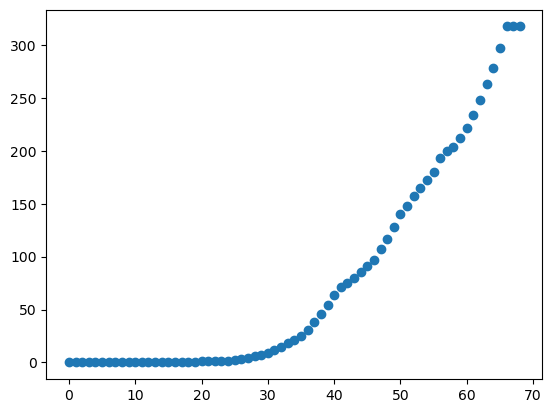

In [74]:
import matplotlib.pyplot as plt

plt.scatter(range(len(la_cum)), la_cum)
plt.show()

In [15]:
constraints_crop = [height_incr, la_incr]
# print(constraints_crop)

In [16]:
def init_visible_length(g):
    
    axes = g.vertices(scale=1)
    metamer_scale = g.max_scale()

    for axis in axes:
        v = next(g.component_roots_at_scale_iter(axis, scale=metamer_scale))

        for metamer in pre_order2(g, v):
            nm = g.node(metamer)

            if "Stem" in nm.label or "Leaf" in nm.label:
                nm.visble_length = 0

    return g

In [17]:
def compute_light_inter(scene):
    
    sky = str(data_path('Turtle16soc.light'))
    # zenith = str(data_path('zenith.light'))
    # opts = map(str, [data_path('par.opt'), data_path('nir.opt')])
    pattern = (-50, -50, 50, 50)
    
    # complete set of files
    cs = CaribuScene(scene=scene, # give mtg rather than scene
                     light=sky, 
                     pattern=pattern, # for toric scene
                     scene_unit='cm',
                     soil_mesh=1) 
    
    raw,agg=cs.run(simplify=True)
    
    scene,values = cs.plot(raw['Ei'],display=False)
    
    v99 = np.percentile(values, 99)
    nvalues=np.array(values)
    nvalues[nvalues>v99]=v99
    values = nvalues.tolist()
    return values

In [81]:
def algo(archi_parameters, constraints_crop, crop_parameters, tt_cum):

    # Fix a seed
    seed(100)

    # Spatial arrangement parameters
    nice_green = Color3((50, 100, 0))
    nb_of_plants, positions, domain, domain_area, unit = agronomic_plot(*crop_parameters, noise=0.1)

    # Generate potential plant of monocrop
    potential_plant = generate_potential_plant(archi_parameters)
    potential_plant = thermal_time(potential_plant)

    # Loop through time
    par_caribu = []
    for i, tt in enumerate(tt_cum):
        constraints_crop_tt = [constraints_crop[0][i], constraints_crop[1][i]]
        constraints_plants = distribute_among_plants(constraints_crop_tt, nb_of_plants)
        growing_plant = grow_plant(potential_plant, tt, constraints_plants)
        plants = [growing_plant] * nb_of_plants
        if i > 0:
            # stand
            scene, nump = build_scene(plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
            # compute light inter
            values = compute_light_inter(scene)
            par_crop = sum(values)*0.0145
            # print(par_crop)
            par_caribu.append(par_crop)
        
    return par_caribu

In [82]:
algo(archi_parameters_combinations[10], constraints_crop, crop_parameters_combinations[1], tt_cum)

ValueError: Sample larger than population or is negative

In [86]:
archis = []
nb_of_plants, positions, domain, domain_area, unit = agronomic_plot(*crop_parameters_combinations[0], noise=0.1)

for archi in archi_parameters_combinations:
    # Generate potential plant of monocrop
    potential_plant = generate_potential_plant(archi)
    potential_plant = thermal_time(potential_plant)

    # Loop through time
    plant = []
    for i, tt in enumerate(tt_cum):
        constraints_crop_tt = [constraints_crop[0][i], constraints_crop[1][i]]
        constraints_plants = distribute_among_plants(constraints_crop_tt, nb_of_plants)
        growing_plant = grow_plant(potential_plant, tt, constraints_plants)
        plant.append(growing_plant)
    archis.append(plant)

In [96]:
# display_in_NB(archis[0][2], tt_cum[0])
nice_green = Color3((50, 100, 0))
plants = [archis[11][2]] * nb_of_plants
scene, nump = build_scene(plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [33]:
par_caribu_dens_10 = []
for archi in archi_parameters_combinations:
    par_caribu = algo(archi, constraints_crop, crop_parameters_combinations[0], tt_cum)
    par_caribu_dens_10.append(par_caribu)

In [56]:
par_caribu_dens_20 = []
for archi in archi_parameters_combinations:
    par_caribu = algo(archi, constraints_crop, crop_parameters_combinations[1], tt_cum)
    par_caribu_dens_20.append(par_caribu)

ValueError: Sample larger than population or is negative

In [36]:
for r in par_caribu_dens_10:
    print(r)

[0.6683904109589041, 0.6683904109589041, 0.6683904109589041, 1.6153794814814815, 1.6153794814814815, 1.6153794814814815, 1.6153794814814815, 3.7007137106918244, 3.7007137106918244, 3.7007137106918244, 3.7007137106918244, 7.316245098039216, 7.316245098039216, 7.316245098039216, 7.316245098039216, 9.07821030612245, 9.07821030612245, 9.07821030612245, 4.044461314741035, 4.044461314741035, 4.044461314741035, 10.429091743119267, 10.429091743119267, 10.429091743119267, 10.895448717948717, 10.895448717948717, 10.973823076923079, 10.973823076923079, 10.973823076923079, 10.548010204081631, 10.548010204081631, 9.956008875739647, 9.956008875739647, 9.956008875739647, 9.618202702702703, 9.618202702702703, 8.992942028985508, 8.992942028985508, 8.992942028985508, 10.921285310734465, 10.921285310734465, 10.921285310734465, 10.599422872340424, 10.599422872340424, 10.599422872340424, 7.356626785714288, 7.356626785714288, 7.356626785714288, 3.978250469043152, 3.978250469043152, 3.978250469043152, 8.7678

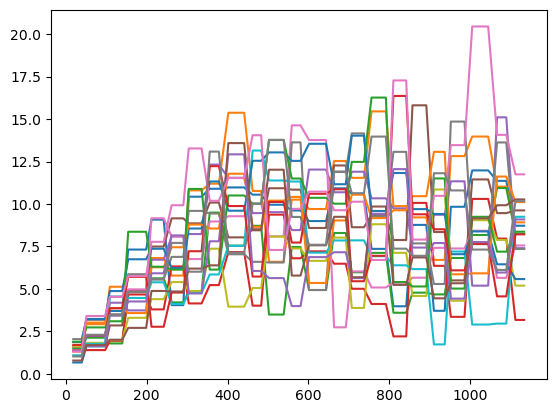

In [39]:
for r in par_caribu_dens_10:
    plt.plot(tt_cum[1:], r)
plt.show()

In [1]:
# Convert to a NumPy array for easier manipulation
curves = par_caribu_dens_10
curves_array = np.array(curves)

# Calculate the envelope: min and max values for each time point
min_values = curves_array.min(axis=0)
max_values = curves_array.max(axis=0)

# Plotting the envelope along with individual curves for context
time_points = tt_cum[1:]
for curve in curves:
    plt.plot(time_points, curve, alpha=0.5, linestyle='--')  # Plot each curve (optional for visualization)

plt.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
plt.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
plt.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
plt.plot(time_points, par[2:], color="black", label="STICS")
plt.scatter(range(len(la_cum)), la_cum)

# Labels and legend
plt.xlabel("Thermal time")
plt.ylabel("PAR intercepted")
plt.title("PAR intercepted: 3D canopy vs. STICS")
plt.legend()
plt.show()

NameError: name 'par_caribu_dens_10' is not defined

In [ ]:
# archi_parameters = archi_parameters_combinations[11]
# g = generate_potential_plant(archi_parameters)
# g = thermal_time(g)
# time = 200
# compute_nb_of_growing_organs(g, time)

In [89]:
from ipywidgets import interact, interactive, IntSlider, fixed

# Enable plotting with PlantGL
%gui qt

def display_plant(g, time):
    nice_green = Color3((50, 100, 0))
    scene, nump = build_scene(
        g, leaf_material = Material(nice_green), stem_material=Material(nice_green)
    )
    return g, scene, nump

def display_in_NB(g, time):
    g, scene, nump=display_plant(g, time)
    w=PlantGL(scene, group_by_color=True)
    w.wireframe=True
    return w

# display_in_NB(g, tt_cum[0])
    
# max_time = max(g.property('end_tt').values())
# interact(display_in_NB, g=fixed(g), time=IntSlider(min=min(tt_cum), max=max(tt_cum), step=100, value=tt_cum[10]))

In [ ]:
from random import *
import time


# Fix a seed
seed(100)

# Initialize the list of plants
plants_in_crop=[]

# Fixed parameters for all plants
length_plot=1
width_plot=1
sowing_density=20
plant_density=sowing_density
inter_row=0.4
nplants, positions, domain, domain_area, unit = agronomic_plot(length_plot, 
                                                               width_plot, 
                                                               sowing_density, 
                                                               plant_density, 
                                                               inter_row, 
                                                               noise=0.1)


# For loop over all the plants in the crop
for n in range(nplants):

    # start_time_1 = time.time()
    g = generate_potential_plant(archi_parameters)
    # print(time.time() - start_time_1, "seconds")
    
    # Fill the list of plants
    plants_in_crop.append(g) # put all plants in the same mtg to be able to visualize the dynamic growth easily

# Build and display scene
nice_green = Color3((50, 100, 0))
scene, nump = build_scene(plants_in_crop, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene)

In [ ]:
# save all MTGs of potential/growing plants
# retrieve growing pattern of each organ

# run STICS simulation with sorghum canopy PAR intercepted as output

# choose number of time steps
# write a function that, for all combinations of parameters (not in notebook, visualisation only to check):
    # generate crops and compute light interception (toric !!) at different time steps
    # get values of PAR intercepted from Caribu 
    # write results in a file

# compare values of PAR intercepted of canopy through time with both models, with and without architectural variability
# per trait and density
# uncertainty analysis

In [ ]:
from alinea.caribu.CaribuScene import CaribuScene
from alinea.caribu.data_samples import data_path

# start_time_1 = time.time()

## Code for computing light interception with Caribu
sky = str(data_path('Turtle16soc.light'))
# zenith = str(data_path('zenith.light'))
# opts = map(str, [data_path('par.opt'), data_path('nir.opt')])
pattern = (-50, -50, 50, 50)

# complete set of files
cs = CaribuScene(scene=scene, # give mtg rather than scene
                 light=sky, 
                 pattern=pattern, # for toric scene
                 scene_unit='cm',
                 soil_mesh=1) 

raw,agg=cs.run(simplify=True)

scene,values = cs.plot(raw['Ei'],display=False)

v99 = np.percentile(values, 99)
nvalues=np.array(values)
nvalues[nvalues>v99]=v99
values = nvalues.tolist()

# print(time.time() - start_time_1, "seconds")

# start_time_2 = time.time()

PlantGL(scene, group_by_color=False, property=values)

# print(time.time() - start_time_2, "seconds")

In [ ]:
# Ei (float): the surfacic density of energy incoming on the triangles (µmol m⁻² s⁻¹)
# raint (float): from STICS, Photosynthetic active radiation intercepted by the canopy 	(MJ m−2)
# PAR(MJ m-2) = 0.0145 * PAR(µmol m⁻² s⁻¹)

print(nplants)
print(len(raw['Ei'].values()))
sum_ei = 0
for t in list(raw['Ei'].values()):
    sum_ei += sum(t)

print(sum_ei*0.0145)